In [2]:
import os
import re
import numpy as np
from numpy.typing import NDArray
import pandas as pd
from typing import Dict, List

# Data

In [3]:
texts = {}
for file in os.listdir("./data/files_clean"):
    language = file.rstrip(".txt")
    with open(f"./data/files_clean/{file}", "r", encoding="utf-8-sig") as f:
        text = f.read()
        texts[language] = text

# EDA

#### Text length

In [42]:
pd.DataFrame({
    "Language": texts.keys(),
    "Length (chr)": [len(value) for value in texts.values()]
}).sort_values("Length (chr)", ascending=False).reset_index(drop=True)

,Language,Length (chr)
0,spanish,461287
1,french,215363
2,greek,202869
3,italian,179806
4,dutch,167336
5,english,142399
6,polish,140147
7,finnish,128907
8,german,126629


#### Number of words

In [43]:
pd.DataFrame({
    "Language": texts.keys(),
    "Words": [len(value.split()) for value in texts.values()]
}).sort_values("Words", ascending=False).reset_index(drop=True)

,Language,Words
0,spanish,79568
1,french,35196
2,greek,33432
3,italian,31835
4,dutch,28956
5,english,25958
6,polish,21616
7,german,20911
8,finnish,18242


# Data embedding

In [4]:
import chromadb
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from openai import OpenAI

In [5]:
def split_text(text: str, max_length: int=1000):
    sentences = re.split(r'(?<=[.!?])\s+', text)
    chunks = []
    current_chunk = ""

    for sentence in sentences:
        if len(current_chunk) + len(sentence) <= max_length:
            current_chunk += " " + sentence
        else:
            current_chunk = current_chunk.strip()
            if len(current_chunk) > 0:
                chunks.append(current_chunk.strip())
            current_chunk = sentence

    if current_chunk:
        chunks.append(current_chunk.strip())

    return chunks


def embedd_texts(texts: Dict, collection, model, embed_miltiple: bool=False,
                 embedding_batch_size: int=100, loading_batch_size: int=100):
    ids = []
    embeddings = []
    documents = []
    metadatas = []

    for language, text in texts.items():
        chunks = split_text(text)
        for i, chunk in enumerate(chunks):
            ids.append(f"{language}_{i}")
            documents.append(chunk)
            metadatas.append({"language": language})

    if embed_miltiple:
        pbar = tqdm(total=len(documents), desc="Text embedding")
        for i in range(0, len(documents), embedding_batch_size):
            pbar.update(embedding_batch_size)
            embeddings.extend(model(documents[i:i+embedding_batch_size]))
    else:
        for chunk in tqdm(documents, desc="Text embedding"):
            embeddings.append(model(chunk))

    pbar = tqdm(total=len(ids), desc="Loading to database")
    for i in range(0, len(ids), loading_batch_size):
        pbar.update(loading_batch_size)
        collection.add(
            ids=ids[i:i+loading_batch_size],
            embeddings=embeddings[i:i+loading_batch_size], 
            documents=documents[i:i+loading_batch_size],
            metadatas=metadatas[i:i+loading_batch_size]
        )
    
    print("Embedding finished")

#### SentenceTransformer - all-MiniLM-L6-v2

In [5]:
chroma_client = chromadb.PersistentClient(path="./vector_db/romeo_and_juliet")
collection = chroma_client.get_or_create_collection("all_MiniLM_L6_v2")
model = SentenceTransformer("all-MiniLM-L6-v2")

def embed(chunk):
    return model.encode(chunk).tolist()

embedd_texts(texts, collection, embed)

Text embedding: 100%|██████████| 1869/1869 [02:07<00:00, 14.62it/s]
Loading to database: 1900it [00:03, 515.65it/s]                          

Embedding finished


#### TF-IDF Vectorizer

In [6]:
chroma_client = chromadb.PersistentClient(path="./vector_db/romeo_and_juliet")
collection = chroma_client.get_or_create_collection("tfidf")
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(texts.values())

def embed(chunk):
    return tfidf_vectorizer.transform([chunk]).toarray()[0]

embedd_texts(texts, collection, embed)

Text embedding: 100%|██████████| 1869/1869 [00:01<00:00, 1370.58it/s]
Loading to database: 1900it [00:44, 42.95it/s]                          

Embedding finished


#### OpenAI - text-embedding-3-small

In [5]:
chroma_client = chromadb.PersistentClient(path="./vector_db/romeo_and_juliet")
collection = chroma_client.get_or_create_collection("text_embedding_3_small")

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

def embed(texts):
    response = client.embeddings.create(
        model="text-embedding-3-small",
        input=texts
    )
    return [item.embedding for item in response.data]

embedd_texts(texts, collection, embed, embed_miltiple=True)

Text embedding: 1900it [01:00, 31.58it/s]                          
Loading to database: 1900it [00:01, 1091.18it/s]

Embedding finished


# Embedding analysis

In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [7]:
def visualize_embeddings(collection_name: str):
    chroma_client = chromadb.PersistentClient(path="./vector_db/romeo_and_juliet")
    collection = chroma_client.get_or_create_collection(collection_name)
    results = collection.get(include=["embeddings", "metadatas"])
    embeddings = results["embeddings"]
    languages = [metadata["language"] for metadata in results["metadatas"]]

    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    embeddings_by_language = {lng: [] for lng in set(languages)}
    for red_emb, lng in zip(reduced_embeddings, languages):
        embeddings_by_language[lng].append(red_emb)
    for lng in embeddings_by_language.keys():
        embeddings_by_language[lng] = np.array(embeddings_by_language[lng])

    centroids = {
        lng: (np.median(embeddings_by_language[lng].T[0]), np.median(embeddings_by_language[lng].T[1]))
        for lng in embeddings_by_language.keys()
    }

    colors = {lng: plt.cm.spring(i/len(languages)*255) for i, lng in enumerate(set(languages))}

    plt.figure(figsize=(8, 6))
    for lng, points in embeddings_by_language.items():
        plt.scatter(points[:, 0], points[:, 1], label=lng, alpha=0.6, color=colors[lng])
        plt.text(centroids[lng][0], centroids[lng][1], lng, fontsize=12, weight="bold", ha="center", va="center")
    plt.title(f"t-SNE Visualization of Embeddings:\n{collection_name}")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.xticks([])
    plt.yticks([])
    plt.show()

#### all-MiniLM-L6-v2

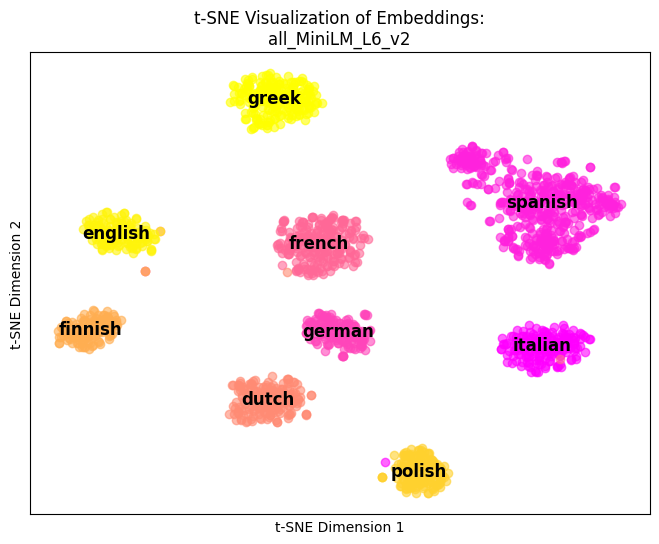

In [8]:
visualize_embeddings("all_MiniLM_L6_v2")

#### TF-IDF

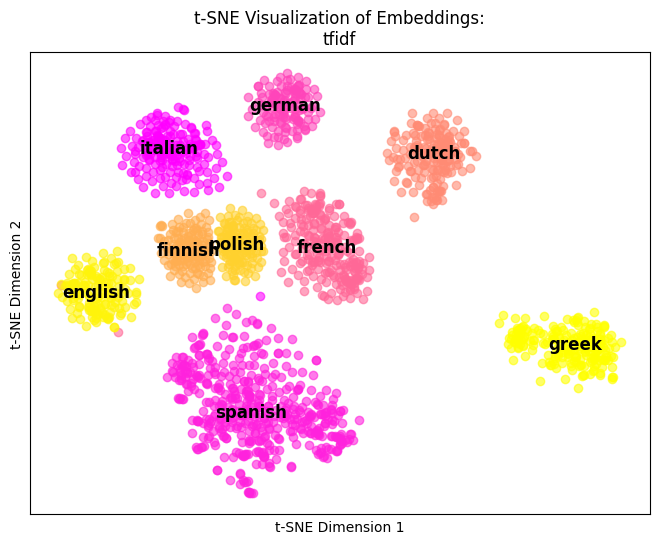

In [9]:
visualize_embeddings("tfidf")

#### text-embedding-3-small

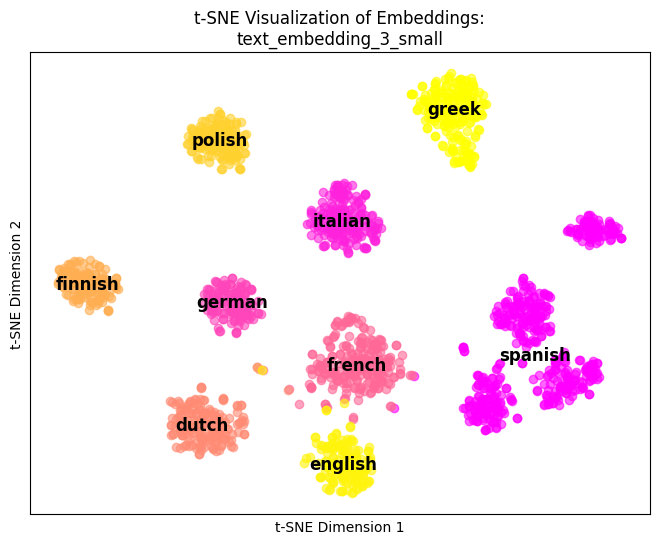

In [10]:
visualize_embeddings("text_embedding_3_small")

# Classification

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

### Data preprocessing

In [8]:
chroma_client = chromadb.PersistentClient(path="./vector_db/romeo_and_juliet")
collection = chroma_client.get_or_create_collection("all_MiniLM_L6_v2")
results = collection.get(include=["embeddings", "metadatas", "documents"])
embeddings = results["embeddings"]
documents = results["documents"]
languages = [metadata["language"] for metadata in results["metadatas"]]

X_train, X_test, y_train, y_test = train_test_split(embeddings, languages, test_size=0.1)

## XGBoost

In [14]:
from xgboost import XGBClassifier

### Model

In [15]:
class XGBClf(XGBClassifier):
    def fit(self, embeddings, languages, *args, **kwargs):
        self.ohe = OneHotEncoder().fit(np.array(languages).reshape((-1, 1)))
        self.language_names = [lng.lstrip("x0_") for lng in self.ohe.get_feature_names_out()]
        super().fit(embeddings, self.encode_languages(languages), *args, **kwargs)
        return self
    
    def encode_languages(self, languages: List) -> NDArray:
        return self.ohe.transform(np.array(languages).reshape((-1, 1))).toarray()

    def decode_languages(self, languages: NDArray) -> list:
        return [self.language_names[np.argmax(vec)] for vec in languages]
    
    def predict(self, X, *args, **kwargs):
        y_pred = super().predict(X, *args, **kwargs)
        y_pred = self.decode_languages(y_pred)
        return y_pred
    
    def __call__(self, X, *args, **kwargs):
        return self.predict(X, *args, **kwargs)

### Evaluation

In [16]:
xgb_clf = XGBClf()
xgb_clf.fit(X_train, y_train)

XGBClf(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, device=None,
       early_stopping_rounds=None, enable_categorical=False, eval_metric=None,
       feature_types=None, feature_weights=None, gamma=None, grow_policy=None,
       importance_type=None, interaction_constraints=None, learning_rate=None,
       max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
       max_delta_step=None, max_depth=None, max_leaves=None,
       min_child_weight=None, missing=nan, monotone_constraints=None,
       multi_strategy=None, n_estimators=None, n_jobs=None,
       num_parallel_tree=None, ...)

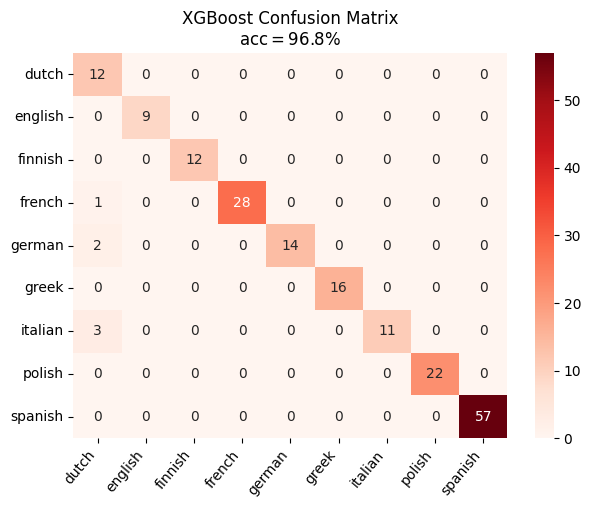

In [17]:
y_pred = xgb_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
conf_mtx = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(conf_mtx, annot=True, cmap="Reds")
plt.xticks(np.arange(0.5, 9.5), xgb_clf.language_names, rotation=50, ha="right")
plt.yticks(np.arange(0.5, 9.5), xgb_clf.language_names, rotation=0)
plt.title(f"XGBoost Confusion Matrix\nacc" + rf"$ = {acc*100:.1f}$" + "%")
plt.show()

# Neural Networks

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### Model

In [22]:
class NeuralNet:
    def __init__(self, n_input: int = 384, n_hidden: int = 64, n_output: int = 9, lr: float = 0.01, epochs: int = 100):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.lr = lr
        self.epochs = epochs
        self.model = None
        self.ohe = None
        self.language_names = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    class Net(nn.Module):
        def __init__(self, n_input, n_hidden, n_output):
            super().__init__()
            self.fc1 = nn.Linear(n_input, n_hidden)
            self.fc2 = nn.Linear(n_hidden, n_output)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.softmax(self.fc2(x), dim=1)
            return x

    def fit(self, embeddings, languages):
        # Encode labels
        self.ohe = OneHotEncoder(sparse_output=False).fit(np.array(languages).reshape(-1, 1))
        self.language_names = [lng.lstrip("x0_") for lng in self.ohe.get_feature_names_out()]
        y_train = self.encode_languages(languages)

        X = torch.tensor(embeddings, dtype=torch.float32).to(self.device)
        y = torch.tensor(y_train, dtype=torch.float32).to(self.device)

        # Initialize model
        self.model = self.Net(self.n_input, self.n_hidden, self.n_output).to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        loss_fn = nn.CrossEntropyLoss()

        for epoch in range(self.epochs):
            self.model.train()
            optimizer.zero_grad()
            output = self.model(X)

            # CrossEntropyLoss expects class indices, not one-hot
            target = torch.argmax(y, dim=1)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            if epoch + 1 == self.epochs:
                print(f"Epoch {epoch + 1}/{self.epochs} - Loss: {loss.item():.4f}")
            else:
                print(f"Epoch {epoch + 1}/{self.epochs} - Loss: {loss.item():.4f}", end="\r")

    def encode_languages(self, languages: List) -> NDArray:
        return self.ohe.transform(np.array(languages).reshape((-1, 1)))

    def decode_languages(self, languages: NDArray) -> list:
        predictions = torch.argmax(languages, dim=1).cpu().numpy()
        return [self.language_names[pred] for pred in predictions]

    def predict(self, embeddings):
        self.model.eval()
        with torch.no_grad():
            X = torch.tensor(embeddings, dtype=torch.float32).to(self.device)
            outputs = self.model(X)
            return self.decode_languages(outputs)

    def __call__(self, embeddings, *args, **kwargs):
        return self.predict(embeddings, *args, **kwargs)

    def __str__(self):
        return f"NeuralNet({self.n_input} -> {self.n_hidden} -> {self.n_output}, epochs={self.epochs}, lr={self.lr})"

### Evaluation

In [24]:
neural_net = NeuralNet(n_hidden=64, epochs=100)
neural_net.fit(X_train, y_train)

Epoch 100/100 - Loss: 1.3745


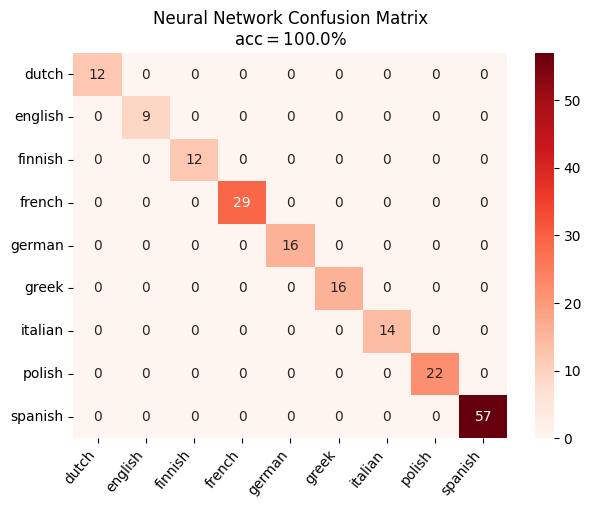

In [25]:
y_pred = neural_net.predict(X_test)
acc = accuracy_score(y_test, y_pred)
conf_mtx = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(conf_mtx, annot=True, cmap="Reds")
plt.xticks(np.arange(0.5, 9.5), xgb_clf.language_names, rotation=50, ha="right")
plt.yticks(np.arange(0.5, 9.5), xgb_clf.language_names, rotation=0)
plt.title(f"Neural Network Confusion Matrix\nacc" + rf"$ = {acc*100:.1f}$" + "%")
plt.show()

## LLM

In [10]:
from openai import OpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from collections.abc import Iterable
import json
from tenacity import retry, wait_fixed, stop_after_attempt

In [11]:
load_dotenv()

True

### Model

In [ ]:
class LLMClf:
    def __init__(self, model: str="gpt-4o-mini", results_path: str="llm_clf_results.json"):
        self.model = model
        self.results_path = results_path
        self.languages = ['dutch', 'english', 'finnish', 'french', 'german', 'greek', 'italian', 'polish', 'spanish']
        self.__system_prompt = (
            "Your task is text language classification. User will give you a "
            "text and you have to classify them to one of this languages:\n"
            "\n".join([f"- {lng}" for lng in self.languages])
        )
        self.client = OpenAI()
        self.Language.model_fields['language'].description = (
            f"Language of a given text. One of: {', '.join(self.languages)}"
        )

    class Language(BaseModel):
        language: str = Field(description="")

    def predict(self, text: str | Iterable[str]) -> str | List[str]:
        if not (isinstance(text, str) or isinstance(text, Iterable)):
            raise TypeError("Incorrect text data type. Should be string or Iterable.")
        
        if isinstance(text, str):
            return self.__predict_text(text)

        if isinstance(text, Iterable):
            results = []
            for i, txt in tqdm(enumerate(text), total=len(text)):
                try:
                    results.append(self.__predict_text(txt))
                except:
                    raise TimeoutError("OpenAI API not responding. Number of requests or tokens exceeded. Error 429.")
                
                if (i+1) % 10 == 0:
                    self.__save_results(results, text[:len(results)], i)

            self.__save_results(results, text, len(results))
            return results

    def __call__(self, text: str, *args, **kwargs) -> str | List[str]:
        return self.predict(text, *args, **kwargs)
    
    @retry(wait=wait_fixed(5), stop=stop_after_attempt(12))
    def __predict_text(self, text: str) -> str:
        messages = [
            {"role": "system", "content": self.__system_prompt},
            {"role": "user", "content": text}
        ]
        completion = self.client.beta.chat.completions.parse(
            model=self.model,
            temperature=0,
            response_format=self.Language,
            messages=messages
        )
        result = completion.choices[0].message.parsed
        return result.language
    
    def __save_results(self, results, documents, id):
        output = {"results": [
            {"id": i, "language": result, "document": document}
            for result, document, i in zip(results, documents, range(id))
        ]}
        with open(self.results_path, "w", encoding="utf-8") as f:
            json.dump(output, f, indent=4)

### Evaluation

In [14]:
llm_clf = LLMClf(results_path="./data/llm_clf_results.json")
y_pred = llm_clf.predict(documents[859:])

100%|██████████| 1010/1010 [13:50<00:00,  1.22it/s]


In [17]:
with open("./data/llm_clf_results.json", "r", encoding="utf-8") as f:
    y_pred = [obj["language"] for obj in json.load(f)["results"]]

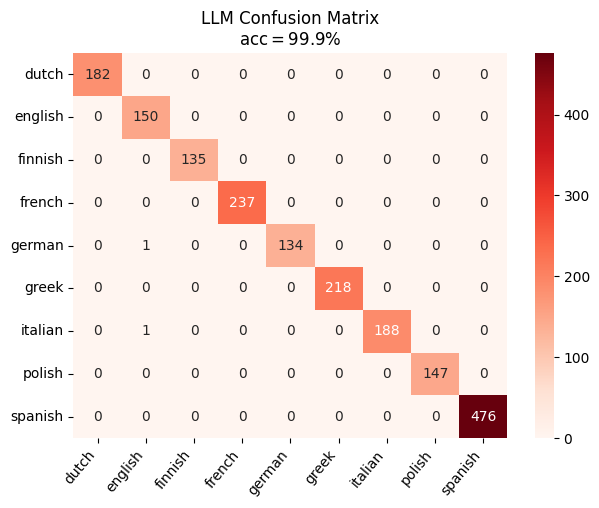

In [26]:
acc = accuracy_score(languages, y_pred)
conf_mtx = confusion_matrix(languages, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(conf_mtx, annot=True, cmap="Reds", fmt="g")
plt.xticks(np.arange(0.5, 9.5), np.unique(languages), rotation=50, ha="right")
plt.yticks(np.arange(0.5, 9.5), np.unique(languages), rotation=0)
plt.title(f"LLM Confusion Matrix\nacc" + rf"$ = {acc*100:.1f}$" + "%")
plt.show()